In [1]:
from tqdm.auto import tqdm
import os, sys

import xml.etree.ElementTree as ET

import numpy as np
import matplotlib.pyplot as plt

from einops import rearrange, repeat, reduce

import jax
import jax.numpy as jnp
from jax.random import split

In [2]:
from color import hsv2rgb

In [3]:
import zipfile
def xml_to_dict(element):
    node = {}
    if element.attrib:
        node.update({f"@{key}": value for key, value in element.attrib.items()})
    children = list(element)
    if children:
        child_dict = {}
        for child in children:
            child_name = child.tag
            child_dict.setdefault(child_name, []).append(xml_to_dict(child))
        for key, value in child_dict.items():
            node[key] = value if len(value) > 1 else value[0]
    else:
        if element.text and element.text.strip():
            node["#text"] = element.text.strip()
    return node

In [4]:

def get_image_load(pid):
    path = f"/Users/akarshkumar0101/spaghetti_old/spaghetti/pbRender/renderedImages/image{pid}.jpg"
    return plt.imread(path)/255.
def get_image_cppn(pid):
    zip_file_path = f'/Users/akarshkumar0101/spaghetti_old/spaghetti/pbRender/genomeAll/{pid}/rep.zip'
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        file_list = zip_ref.namelist()
        assert len(file_list) == 1
        for file_name in file_list:
            with zip_ref.open(file_name) as file:
                file_content = file.read().decode('utf-8')
    root = xml_to_dict(ET.fromstring(file_content))
    if 'genome' not in root:
        root = dict(genome=root)
    nn = get_nn(root)
    res = 256
    x = y = np.linspace(-1., 1., res)
    x, y = np.meshgrid(x, y)
    d = np.sqrt(x**2 + y**2)*1.4
    out = nn_forward(nn, x, y, d)

    out_nodes = [node for node in nn['nodes'] if node['type']=='out']
    if len(out_nodes)==1:
        assert out_nodes[0]['label'] == 'ink'
        brightness_id = out_nodes[0]['id']
        brightness = out[brightness_id]
        brightness = np.abs(brightness)
        rgb = repeat(brightness, 'h w -> h w c', c=3)
    if len(out_nodes)==3:
        assert 'hue' in [node['label'] for node in out_nodes]
        assert 'saturation' in [node['label'] for node in out_nodes]
        assert 'brightness' in [node['label'] for node in out_nodes]
        hue_id = [node['id'] for node in out_nodes if node['label']=='hue'][0]
        saturation_id = [node['id'] for node in out_nodes if node['label']=='saturation'][0]
        brightness_id = [node['id'] for node in out_nodes if node['label']=='brightness'][0]
        hue, saturation, brightness = out[hue_id], out[saturation_id], out[brightness_id]
        r, g, b = hsv2rgb((hue+1)%1, saturation.clip(0,1), np.abs(brightness).clip(0, 1))
        rgb = np.stack([r, g, b], axis=-1)
    return rgb, nn

In [5]:
def load_nn(pid):
    zip_file_path = f'/Users/akarshkumar0101/spaghetti_old/spaghetti/pbRender/genomeAll/{pid}/rep.zip'
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        file_list = zip_ref.namelist()
        assert len(file_list) == 1
        for file_name in file_list:
            with zip_ref.open(file_name) as file:
                file_content = file.read().decode('utf-8')
    root = xml_to_dict(ET.fromstring(file_content))
    if 'genome' not in root:
        root = dict(genome=root)

    ns, ls = [], []
    nodes_ = root['genome']['nodes']['node']
    links_ = root['genome']['links']['link']
    nodes, links = [], []
    for node in nodes_:
        # node = dict(type=node['@type'], label=node['@label'] if '@label' in node else "", id=int(node['marking']['@id']), activation=node['activation']['#text'][:-3])
        node = dict(label=node['@label'] if '@label' in node else "", id=int(node['marking']['@id']), activation=node['activation']['#text'][:-3])
        nodes.append(node)
    for link in links_:
        link = dict(id=int(link['marking']['@id']), source=int(link['source']['@id']), target=int(link['target']['@id']), weight=float(link['weight']['#text']))
        links.append(link)

    if 'ink' in [node['label'] for node in nodes]: # convert ink output to hsv standard
        node_v = [node for node in nodes if node['label'] == 'ink'][0]
        node_v['label'] = 'brightness'
        nodes.append(dict(label='hue', id=1000000, activation='identity'))
        nodes.append(dict(label='saturation', id=1000001, activation='identity'))
        links.append(dict(id=1000002, source=node_v['id'], target=1000000, weight=0.))
        links.append(dict(id=1000003, source=node_v['id'], target=1000001, weight=0.))

    special_nodes = {}
    special_nodes['x'] = [node['id'] for node in nodes if node['label'] == 'x'][0]
    special_nodes['y'] = [node['id'] for node in nodes if node['label'] == 'y'][0]
    special_nodes['d'] = [node['id'] for node in nodes if node['label'] == 'd'][0]
    special_nodes['bias'] = [node['id'] for node in nodes if node['label'] == 'bias'][0]
    special_nodes['h'] = [node['id'] for node in nodes if node['label'] == 'hue'][0]
    special_nodes['s'] = [node['id'] for node in nodes if node['label'] == 'saturation'][0]
    special_nodes['v'] = [node['id'] for node in nodes if node['label'] == 'brightness'][0]
    # links = [link for link in links if link['weight'] != 0.]
    return dict(nodes=nodes, links=links, special_nodes=special_nodes)

In [20]:
identity = lambda x: x
cos = jnp.cos
sin = jnp.sin
tanh = jnp.tanh
sigmoid = lambda x: jax.nn.sigmoid(x) * 2. - 1.
gaussian = lambda x: jnp.exp(-x**2) * 2. - 1.
relu = jax.nn.relu

activation_fn_map = dict(identity=identity, cos=cos, sin=sin, tanh=tanh, sigmoid=sigmoid, gaussian=gaussian, relu=relu)

def do_forward_pass(nn):
    res = 256
    x = y = jnp.linspace(-1., 1., res)
    x, y = jnp.meshgrid(x, y)
    d = jnp.sqrt(x**2 + y**2)*1.4
    b = jnp.ones_like(x)

    node2activation = {n['id']: n['activation'] for n in nn['nodes']}
    node2out_links = {n['id']: [(l['target'], l['weight']) for l in nn['links'] if l['source'] == n['id']] for n in nn['nodes']}
    node2in_links = {n['id']: [(l['source'], l['weight']) for l in nn['links'] if l['target'] == n['id']] for n in nn['nodes']}

    node_x = nn['special_nodes']['x']
    node_y = nn['special_nodes']['y']
    node_d = nn['special_nodes']['d']
    node_b = nn['special_nodes']['bias']
    node_h = nn['special_nodes']['h']
    node_s = nn['special_nodes']['s']
    node_v = nn['special_nodes']['v']

    node2val = {} #{node['id']: np.zeros_like(x) for node in nn['nodes']}
    node2val[node_x], node2val[node_y], node2val[node_d], node2val[node_b] = x, y, d, b

    def get_value_recur(node, path=[]):
        if node in node2val:
            return node2val[node]
        if node in path:
            print(f'CYCLE: {path}')
            return jnp.zeros_like(x)
        val = jnp.zeros_like(x)
        for node_src, weight in node2in_links[node]:
            val = val + weight * get_value_recur(node_src, path=path+[node])
        node2val[node] = activation_fn_map[node2activation[node]](val)
        return node2val[node]

    for node in [node_h, node_s, node_v]: # actual forward pass
        get_value_recur(node, path=[])
    
    h, s, v = node2val[node_h], node2val[node_s], node2val[node_v]
    r, g, b = hsv2rgb((h+1)%1, s.clip(0,1), jnp.abs(v).clip(0, 1))
    rgb = jnp.stack([r, g, b], axis=-1)

    node2layer = {node_x: 0, node_y: 0, node_d: 0, node_b: 0}
    i_layer = 1
    while True: # get the layer numbers of each node
        nodes_in_layer = []
        for node in node2val:
            if node in node2layer:
                continue
            if all(src in node2layer for src, _ in node2in_links[node]):
                nodes_in_layer.append(node)
        for node in nodes_in_layer:
            node2layer[node] = i_layer
        i_layer += 1
        if not nodes_in_layer:
            break
    
    n_layers = max(node2layer.values()) + 1
    nodes_cache = [[] for i in range(n_layers)]
    for node in node2val: # calculate the cache of each node
        layer_start = node2layer[node]
        if node in [node_h, node_s, node_v]:
            layer_end = n_layers
        elif len(node2out_links[node])>0:
            layer_end = max([node2layer[target] for target, _ in node2out_links[node]])
        for i in range(layer_start, layer_end):
            nodes_cache[i].append((node, i==layer_start))
    
    print("n_nodes=", len(node2val))
    print("n_layers=", n_layers)
    from collections import defaultdict
    amax = defaultdict(int)
    for i_layer, nodes_layer in enumerate(nodes_cache):
        a = defaultdict(int)
        for node, novel in nodes_layer:
            a[node2activation[node] if novel else "C"] += 1
        for k in a:
            amax[k] = max(amax[k], a[k])
        # print(dict(a))
    amax = dict(amax)
    print(amax)
    width = sum(amax.values())
    print("width=", width)

    print("parameters=", width*width*n_layers)

    features = [jnp.stack([node2val[node] for node, _ in nodes_cache[i]], axis=-1) for i in range(n_layers)]

    # outputs = dict(rgb=rgb, node2val=node2val, node2layer=node2layer, features=features)
    return rgb, node2val, node2layer, nodes_cache, features

In [41]:
# net = load_nn(4376)
net = load_nn(576)
# net = load_nn(5736)
# net = load_nn(9382)
img, node2val, node2layer, nodes_cache, features_pb = do_forward_pass(net)

n_nodes= 25
n_layers= 13
{'identity': 4, 'C': 15, 'gaussian': 4, 'sin': 1}
width= 24
parameters= 7488


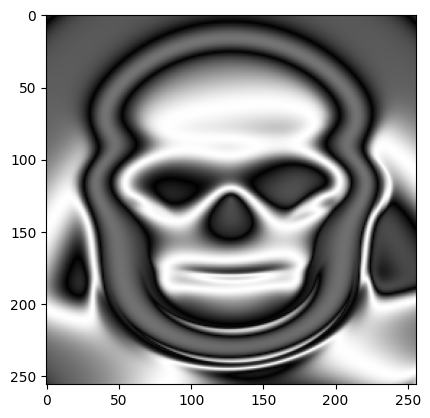

In [42]:
plt.imshow(img)

In [43]:
# from matplotlib.colors import LinearSegmentedColormap
# cmap = LinearSegmentedColormap.from_list('red_white_blue', ['red', 'white', 'blue'])
def viz_feature_maps(img, features):
    max_features_per_layer = max(jax.tree.map(lambda x: x.shape[-1], features))
    n_layers = len(features)
    n_layers, max_features_per_layer

    plt.figure(figsize=(1*max_features_per_layer, 1*n_layers))
    for i, layer_features in enumerate(features):
        for j, fmap in enumerate(rearrange(layer_features, 'h w c -> c h w')):
            plt.subplot(n_layers, max_features_per_layer, i*max_features_per_layer + j + 1)
            plt.imshow(fmap, cmap='bwr_r', vmin=-1.0, vmax=1.0); plt.xticks([]); plt.yticks([])
            if j==0:
                plt.ylabel(f"{i}", fontsize=25)
            for spine in plt.gca().spines.values():
                spine.set_edgecolor('black')
                spine.set_linewidth(1)
    # plt.subplot(n_layers, max_features_per_layer, (n_layers-1)*max_features_per_layer + (max_features_per_layer-1) + 1)
    # plt.imshow(rgb); plt.axis('off')
    plt.gcf().supylabel("Layer", fontsize=35)
    plt.gcf().supxlabel("Feature Map", fontsize=35)
    plt.suptitle("Feature Maps of CPPN", fontsize=35)
    plt.tight_layout()
    return plt.gcf()

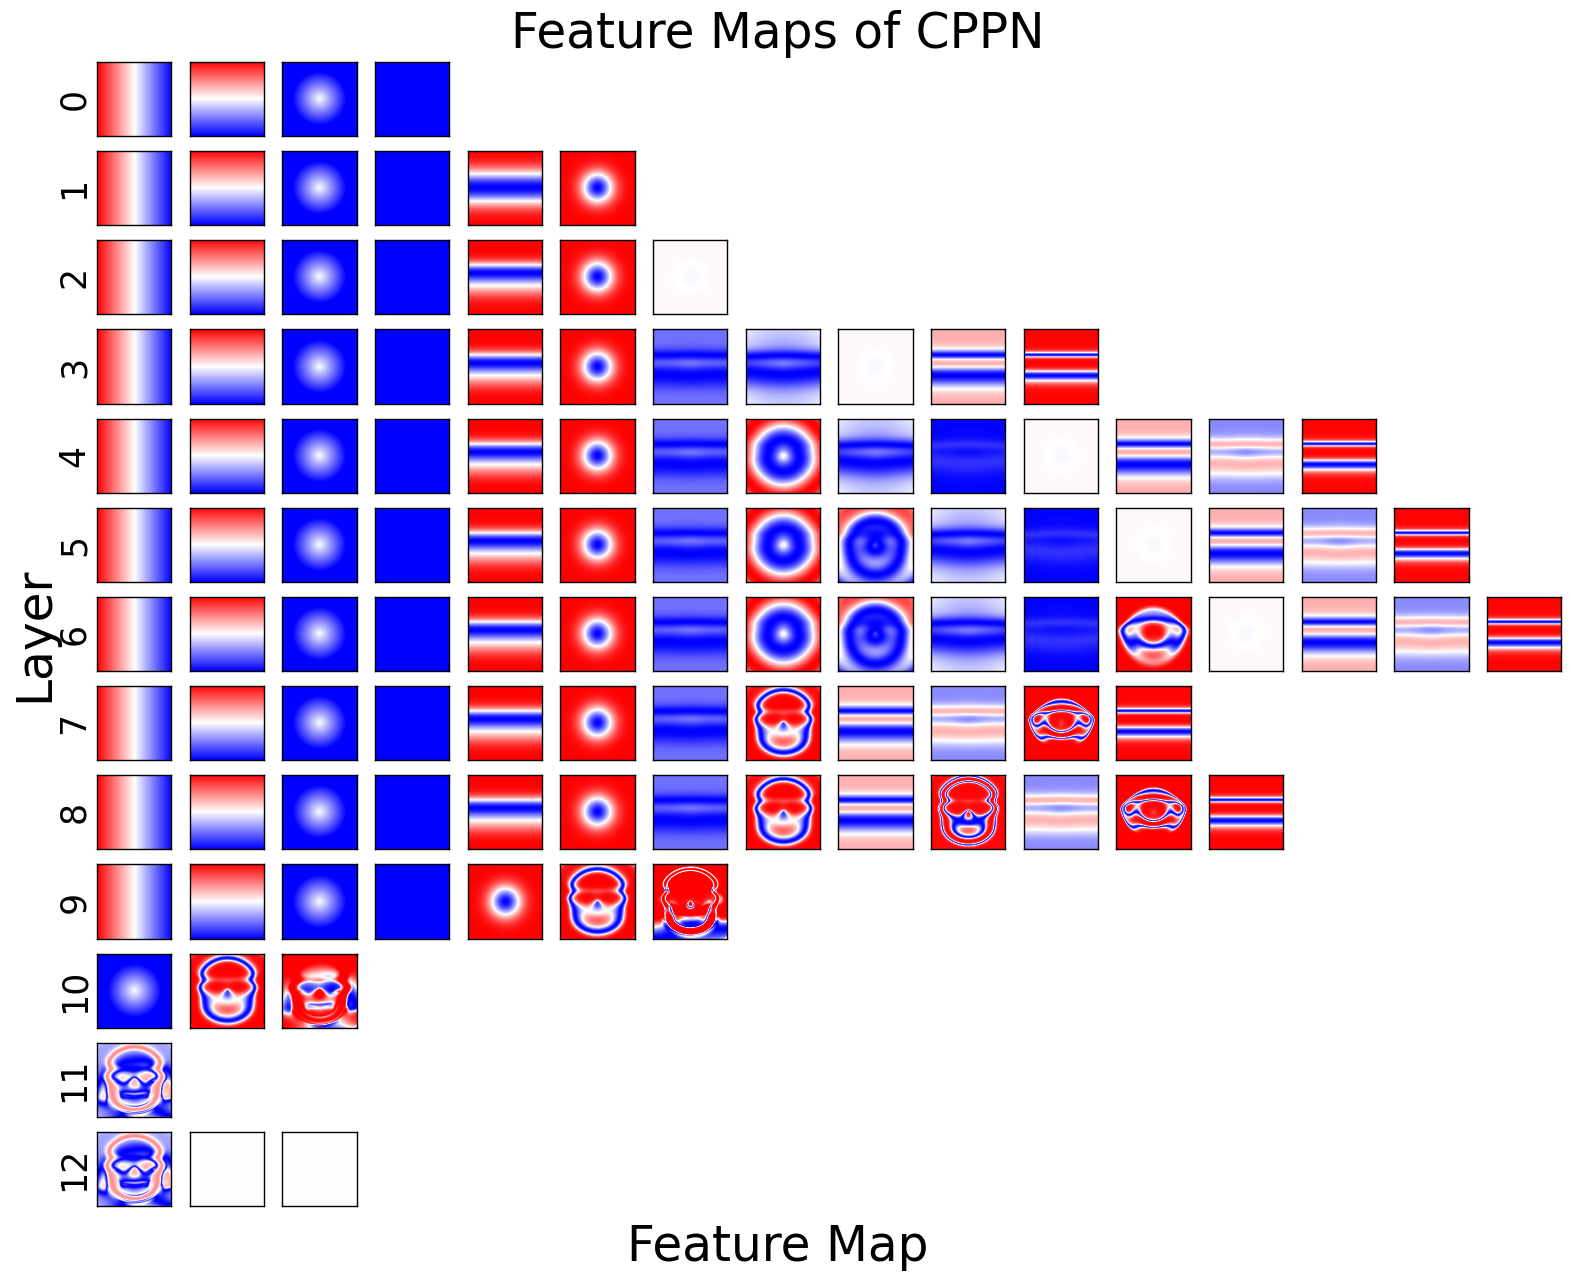

In [44]:
viz_feature_maps(img, features_pb)
plt.show()

In [81]:
from functools import partial
import jax
import jax.numpy as jnp
from jax.random import split
import flax
import flax.linen as nn
from einops import rearrange
import evosax
from color import hsv2rgb

cache = lambda x: x
identity = lambda x: x
cos = jnp.cos
sin = jnp.sin
tanh = jnp.tanh
sigmoid = lambda x: jax.nn.sigmoid(x) * 2. - 1.
gaussian = lambda x: jnp.exp(-x**2) * 2. - 1.
relu = jax.nn.relu

activation_fn_map = dict(cache=cache, identity=identity, cos=cos, sin=sin, tanh=tanh, sigmoid=sigmoid, gaussian=gaussian, relu=relu)

class CPPN(nn.Module):
    n_layers: int
    # d_hidden: int
    # nonlins: str = "relu" # "sin,tanh,sigmoid,gaussian,relu"
    activation_neurons: str = "relu:20"
    inputs: str = "y,x,d,b" # "x,y,d,b,xabs,yabs"

    @nn.compact
    def __call__(self, x):
        activations = [i.split(":")[0] for i in self.activation_neurons.split(",")]
        d_hidden = jnp.array([int(i.split(":")[-1]) for i in self.activation_neurons.split(",")])

        features = [x]
        for i_layer in range(self.n_layers):
            x = nn.Dense(sum(d_hidden), use_bias=False)(x)

            x = jnp.split(x, jnp.cumsum(d_hidden))
            x = [activation_fn_map[activation](xi) for xi, activation in zip(x, activations)]
            x = jnp.concatenate(x)

            features.append(x)
        x = nn.Dense(3, use_bias=False)(x)
        features.append(x)
        # h, s, v = jax.nn.tanh(x) # CHANGED THIS TO TANH
        h, s, v = x
        return (h, s, v), features

    def generate_image(self, params, img_size=256, return_features=False):
        inputs = {}
        x = y = jnp.linspace(-1, 1, img_size)
        inputs['x'], inputs['y'] = jnp.meshgrid(x, y, indexing='ij')
        inputs['d'] = jnp.sqrt(inputs['x']**2 + inputs['y']**2) * 1.4
        inputs['b'] = jnp.ones_like(inputs['x'])
        inputs['xabs'], inputs['yabs'] = jnp.abs(inputs['x']), jnp.abs(inputs['y'])
        inputs = [inputs[input_name] for input_name in self.inputs.split(",")]
        inputs = jnp.stack(inputs, axis=-1)
        (v, s, h), features = jax.vmap(jax.vmap(partial(self.apply, params)))(inputs)
        r, g, b = hsv2rgb((h+1)%1, s.clip(0,1), jnp.abs(v).clip(0, 1))
        rgb = jnp.stack([r, g, b], axis=-1)
        if return_features:
            return rgb, features
        else:
            return rgb

class FlattenCPPNParameters():
    def __init__(self, cppn):
        self.cppn = cppn

        rng = jax.random.PRNGKey(0)
        d_in = len(self.cppn.inputs.split(","))
        self.param_reshaper = evosax.ParameterReshaper(self.cppn.init(rng, jnp.zeros((d_in,))))
        self.n_params = self.param_reshaper.total_params
    
    def init(self, rng):
        d_in = len(self.cppn.inputs.split(","))
        params = self.cppn.init(rng, jnp.zeros((d_in,)))
        return self.param_reshaper.flatten_single(params)

    def generate_image(self, params, img_size=256, return_features=False):
        params = self.param_reshaper.reshape_single(params)
        return self.cppn.generate_image(params, img_size=img_size, return_features=return_features)

In [82]:
cppn = CPPN(12, "cache:15,identity:0,sin:1,cos:0,gaussian:4,sigmoid:0")
cppn = FlattenCPPNParameters(cppn)
params = jnp.zeros(cppn.n_params)
params = cppn.param_reshaper.reshape_single(params)


ParameterReshaper: 4540 parameters detected for optimization.


In [83]:
def get_weight_matrix(net, i_layer, nodes_cache, activation_neurons="cache:15,identity:0,sin:1,cos:0,gaussian:4,sigmoid:0"):
    node2activation = {n['id']: n['activation'] for n in net['nodes']}

    activations = [i.split(":")[0] for i in activation_neurons.split(",")]
    d_hidden = np.array([int(i.split(":")[-1]) for i in activation_neurons.split(",")])

    position_offset = {act: p for act, p in zip(activations, np.cumsum(np.array([0]+list(d_hidden)[:-1])))}


    def get_position_within_layer(nodes_caches_layer, node): # node_id
        i_node = [n for n, _ in nodes_caches_layer].index(node)

        node, act = nodes_caches_layer[i_node]
        p = 0
        for n, a in nodes_caches_layer:
            if n==node:
                break
            elif a==act:
                p+=1
        p = p + position_offset[act]
        return p

    # print(activations, d_hidden)

    prev_layer = nodes_cache[i_layer]
    this_layer = nodes_cache[i_layer+1]
    prev_layer = [(a, 'cache' if not b else node2activation[a]) for a, b in prev_layer]
    this_layer = [(a, 'cache' if not b else node2activation[a]) for a, b in this_layer]

    if i_layer==0:
        prev_layer = [(a, 'cache') for a, _ in prev_layer]

    # print(prev_layer)
    # print(this_layer)
    # print()

    weight_mat = np.zeros((sum(d_hidden), sum(d_hidden)))
    for n, act in this_layer:
        p = get_position_within_layer(this_layer, n)
        if act=='cache':
            p2 = get_position_within_layer(prev_layer, n)
            # print(n, act, p, p2)
            weight_mat[p, p2] = 1.
        else:
            for src, w in [(l['source'], l['weight']) for l in net['links'] if l['target']==n]:
                p2 = get_position_within_layer(prev_layer, src)
                weight_mat[p, p2] = w
    return weight_mat.T

weight_mats = np.stack([get_weight_matrix(net, i_layer, nodes_cache) for i_layer in range(len(nodes_cache)-1)])

In [84]:
for i_layer in range(len(nodes_cache)-1):
    a, b = params['params'][f'Dense_{i_layer}']['kernel'].shape
    w = weight_mats[i_layer][:a, :b]
    params['params'][f'Dense_{i_layer}']['kernel'] = jnp.array(w)

In [85]:
a, b = params['params']['Dense_12']['kernel'].shape
params['params']['Dense_12']['kernel'] = jnp.eye(a, b)

In [86]:
params

{'params': {'Dense_0': {'kernel': Array([[ 1.       ,  0.       ,  0.       ,  0.       ,  0.       ,
            0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
            0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
            0.       ,  0.       ,  0.       ,  0.       ,  0.       ],
          [ 0.       ,  1.       ,  0.       ,  0.       ,  0.       ,
            0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
            0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
            0.       , -2.2616582,  0.       ,  0.       ,  0.       ],
          [ 0.       ,  0.       ,  1.       ,  0.       ,  0.       ,
            0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
            0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
            0.       ,  0.       ,  1.7264186,  0.       ,  0.       ],
          [ 0.       ,  0.       ,  0.       ,  1.       ,  0.       ,
            0.       ,  0.       ,  0.     

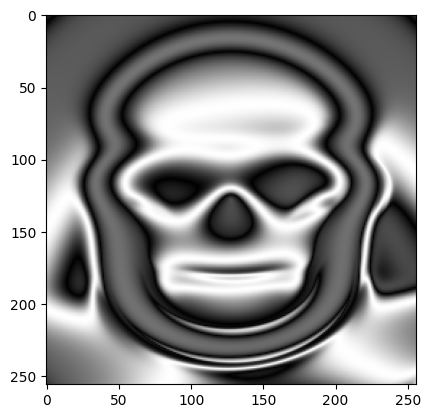

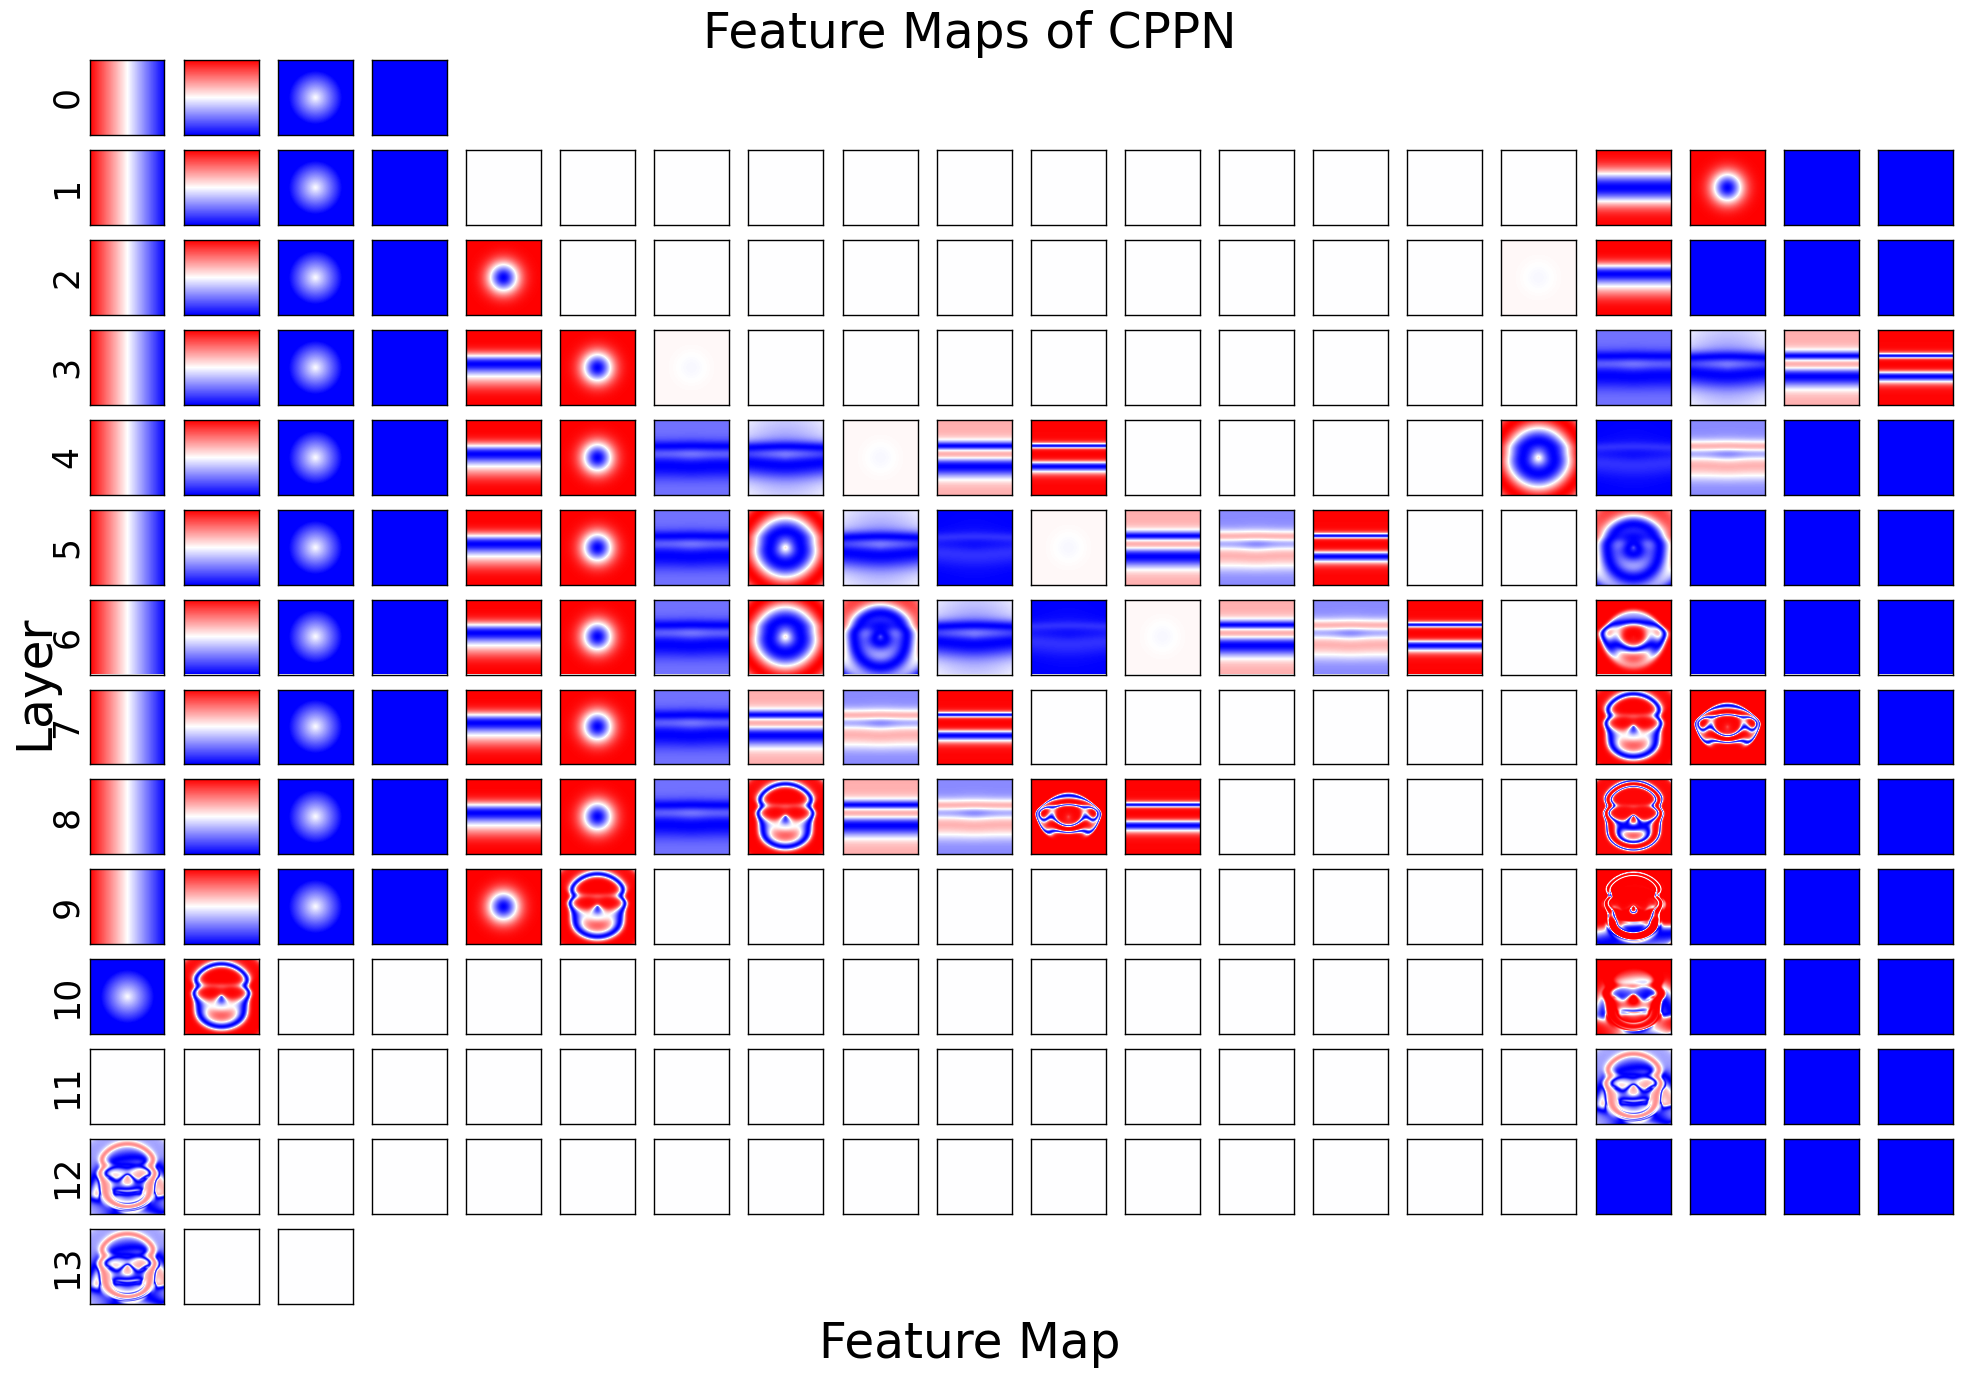

In [87]:
img, features = cppn.generate_image(cppn.param_reshaper.flatten_single(params), return_features=True)
plt.imshow(img)
viz_feature_maps(img, features)
plt.show()

In [90]:
cppn.param_reshaper.flatten_single(params).shape

(4540,)

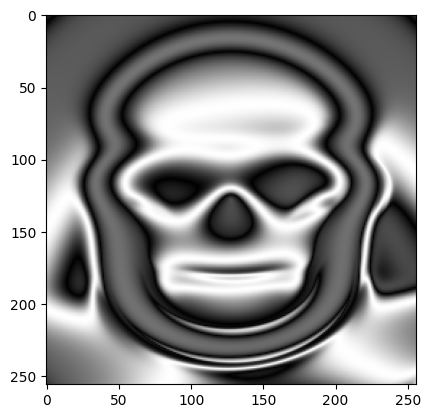

In [88]:
img, features = cppn.generate_image(cppn.param_reshaper.flatten_single(params), return_features=True)
plt.imshow(img)

In [4]:

# Path to the zip file
zip_file_path = '/Users/akarshkumar0101/spaghetti_old/spaghetti/pbRender/genomeAll/576/rep.zip'
# zip_file_path = '/Users/akarshkumar0101/spaghetti_old/spaghetti/pbRender/genomeAll/5736/rep.zip'

# zip_file_path = '/Users/akarshkumar0101/spaghetti_old/spaghetti/pbRender/genomeAll/4323/rep.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    file_list = zip_ref.namelist()
    assert len(file_list) == 1
    for file_name in file_list:
        with zip_ref.open(file_name) as file:
            file_content = file.read().decode('utf-8')

In [5]:
# save the content to a file
# with open('temp', 'w') as f:
    # f.write(file_content)


In [6]:
root = xml_to_dict(ET.fromstring(file_content))
if 'genome' not in root:
    root = dict(genome=root)

In [7]:
def get_nn(root):
    ns, ls = [], []
    nodes_ = root['genome']['nodes']['node']
    links_ = root['genome']['links']['link']
    nodes, links = [], []
    for node in nodes_:
        node = dict(type=node['@type'], label=node['@label'] if '@label' in node else "", id=int(node['marking']['@id']), activation=node['activation']['#text'])
        nodes.append(node)
    for link in links_:
        link = dict(id=int(link['marking']['@id']), source=int(link['source']['@id']), target=int(link['target']['@id']), weight=float(link['weight']['#text']))
        links.append(link)
    out_node_ids = [node['id'] for node in nodes if node['type'] == 'out']
    in_node_ids = [node['id'] for node in nodes if node['type'] == 'in']
    return dict(nodes=nodes, links=links, out_node_ids=out_node_ids, in_node_ids=in_node_ids)
nn = get_nn(root)
nn

{'nodes': [{'type': 'hidden',
   'label': '',
   'id': 30,
   'activation': 'gaussian(x)'},
  {'type': 'hidden', 'label': '', 'id': 64, 'activation': 'gaussian(x)'},
  {'type': 'hidden', 'label': '', 'id': 201, 'activation': 'gaussian(x)'},
  {'type': 'hidden', 'label': '', 'id': 223, 'activation': 'gaussian(x)'},
  {'type': 'hidden', 'label': '', 'id': 238, 'activation': 'gaussian(x)'},
  {'type': 'hidden', 'label': '', 'id': 281, 'activation': 'gaussian(x)'},
  {'type': 'hidden', 'label': '', 'id': 298, 'activation': 'gaussian(x)'},
  {'type': 'hidden', 'label': '', 'id': 321, 'activation': 'gaussian(x)'},
  {'type': 'hidden', 'label': '', 'id': 360, 'activation': 'gaussian(x)'},
  {'type': 'in', 'label': 'bias', 'id': 0, 'activation': 'identity(x)'},
  {'type': 'in', 'label': 'd', 'id': 1, 'activation': 'identity(x)'},
  {'type': 'in', 'label': 'x', 'id': 2, 'activation': 'identity(x)'},
  {'type': 'in', 'label': 'y', 'id': 3, 'activation': 'identity(x)'},
  {'type': 'out', 'label':

In [69]:
def identity(x):
    return x
def cos(x):
    return np.cos(x)
def sin(x):
    return np.sin(x)
def tanh(x):
    return np.tanh(x)
def sigmoid(x):
    # return 1. / (1. + np.exp(-x))
    return 1. / (1. + np.exp(-x)) * 2.-1.
    # double actualSigmoid ( double input ) {
	# 	return (1.0 / (1+std::exp(float(-input)))) * 2.0 - 1.0;
	# }
def gaussian(x, mu=0., sigma=1.):
    # return np.exp(-0.5 * ((x - mu) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))
    # return np.exp(-x**2)
    return np.exp(-x**2)*2.-1.
    # double actualGaussian ( double input ) {
	# 	return std::exp(float(-input*input)) * 2.0 - 1.0;
	# }

activation_fn_map = dict(identity=identity, cos=cos, sin=sin, sigmoid=sigmoid, tanh=tanh, gaussian=gaussian)

def nn_forward(nn, x, y, d):
    node_id2activation = {n['id']: n['activation'] for n in nn['nodes']}
    # print(node_id2activation)
    node_id2in_links = {n['id']: [(l['source'], l['weight']) for l in nn['links'] if l['target'] == n['id']] for n in nn['nodes']}
    # print(node_id2in_links)

    node_id2type = {n['id']: n['type'] for n in nn['nodes']}
    node_id2label = {n['id']: (n['label'] if 'label' in n else None) for n in nn['nodes']}
    # print(node_id2label)
    # print(node_id2type)
    
    node_id2val = {}
    for node_id in nn['in_node_ids']:
        if node_id2label[node_id] == 'x':
            node_id2val[node_id] = x
        elif node_id2label[node_id] == 'y':
            node_id2val[node_id] = y
        elif node_id2label[node_id] == 'd':
            node_id2val[node_id] = d
        elif node_id2label[node_id] == 'bias':
            node_id2val[node_id] = np.ones_like(x)
        else:
            raise ValueError(f"Unknown input node label: {node_id2label[node_id]}")

    def get_value_recur(node_id, path=[]):
        if node_id in node_id2val:
            return node_id2val[node_id]
        if node_id in path:
            print(f'CYCLE: {path}')
            return 0.

        in_links = node_id2in_links[node_id]
        # print(node_id2activation[node_id])
        activation_fn = activation_fn_map[node_id2activation[node_id][:-3]]
        val = 0.
        for src_id, weight in in_links:
            val += get_value_recur(src_id, path=path+[node_id]) * weight
        node_id2val[node_id] = activation_fn(val)
        return node_id2val[node_id]

    for node_id in nn['out_node_ids']:
        get_value_recur(node_id, path=[])
    return node_id2val

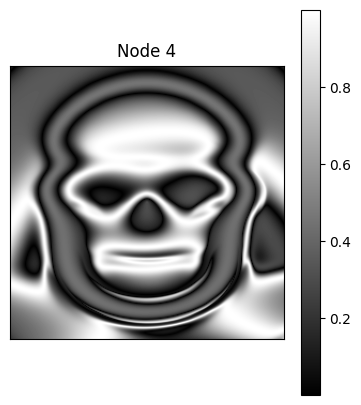

In [70]:
res = 256
x = y = np.linspace(-1., 1., res)
x, y = np.meshgrid(x, y)
d = np.sqrt(x**2 + y**2)*1.4
out = nn_forward(nn, x, y, d)

iplt = 0
plt.figure(figsize=(15, 5))
for node_id in nn['out_node_ids']:
    iplt += 1
    plt.subplot(1, 3, iplt)
    plt.title(f"Node {node_id}")
    plt.imshow(np.abs(out[node_id]), cmap='gray')
    plt.colorbar()
    plt.xticks([]); plt.yticks([])
plt.show()


In [10]:
hsv = []
for node_id in nn['out_node_ids']:
    hsv.append(out[node_id])
v, h, s = hsv
print(h.min(), h.max())
print(s.min(), s.max())
print(v.min(), v.max())
hsv = np.stack([h, s, v], axis=-1)
# hsv = (hsv+1)/2.
hsv.shape

ValueError: not enough values to unpack (expected 3, got 1)

In [11]:
def hsv2rgb(hsv):
    h, s, v = hsv
    h = h * 360.

    c = v * s
    x = c * (1 - jnp.abs((h / 60) % 2 - 1))
    m = v - c
    rgbp1, c1 = jnp.stack([c, x, 0], axis=-1), (0 <= h)*(h<60)
    rgbp2, c2 = jnp.stack([x, c, 0], axis=-1), (60 <= h)*(h<120)
    rgbp3, c3 = jnp.stack([0, c, x], axis=-1), (120 <= h)*(h<180)
    rgbp4, c4 = jnp.stack([0, x, c], axis=-1), (180 <= h)*(h<240)
    rgbp5, c5 = jnp.stack([x, 0, c], axis=-1), (240 <= h)*(h<300)
    rgbp6, c6 = jnp.stack([c, 0, x], axis=-1), (300 <= h)*(h<360)
    rgbp = rgbp1 * c1 + rgbp2 * c2 + rgbp3 * c3 + rgbp4 * c4 + rgbp5 * c5 + rgbp6 * c6
    rgb = rgbp + m
    return rgb.clip(0., 1.)

([], [])

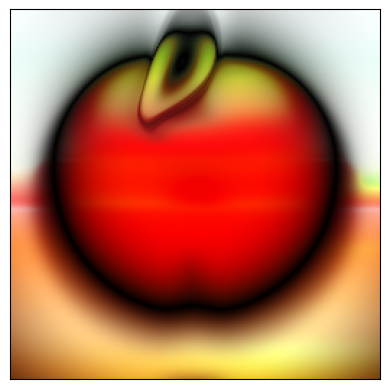

In [337]:
hsv = np.stack([((h+1)/1.4), (s+1)/2., np.abs(v)], axis= -1)
rgb = jax.vmap(jax.vmap(hsv2rgb))(hsv)
plt.imshow(rgb); plt.xticks([]); plt.yticks([])

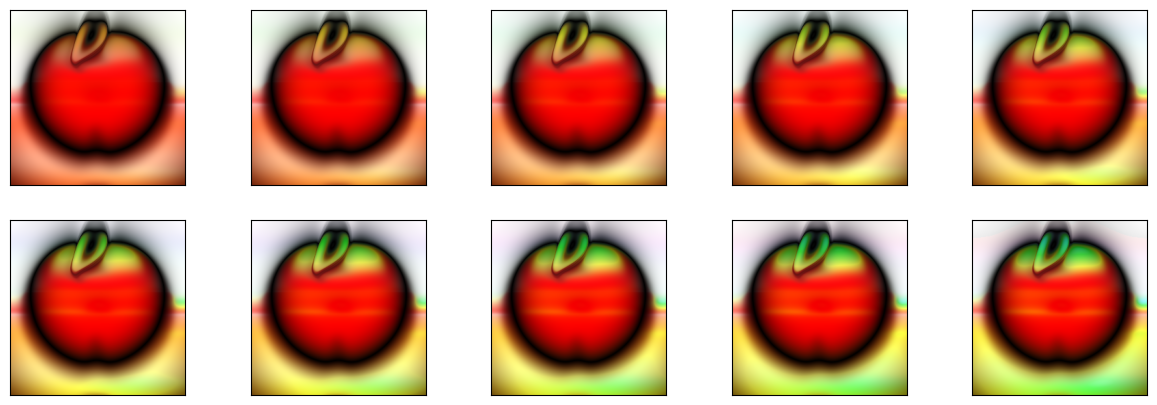

In [310]:
iplt = 0
plt.figure(figsize=(15, 5))
for i in np.linspace(0.7, 3.0, 10):
    hsv = np.stack([((h+1)/2.)*i, (s+1)/2., np.abs(v)], axis=-1)
    rgb = jax.vmap(jax.vmap(hsv2rgb))(hsv)

    iplt += 1
    plt.subplot(2, 5, iplt)
    plt.imshow(rgb); plt.xticks([]); plt.yticks([])
plt.show()

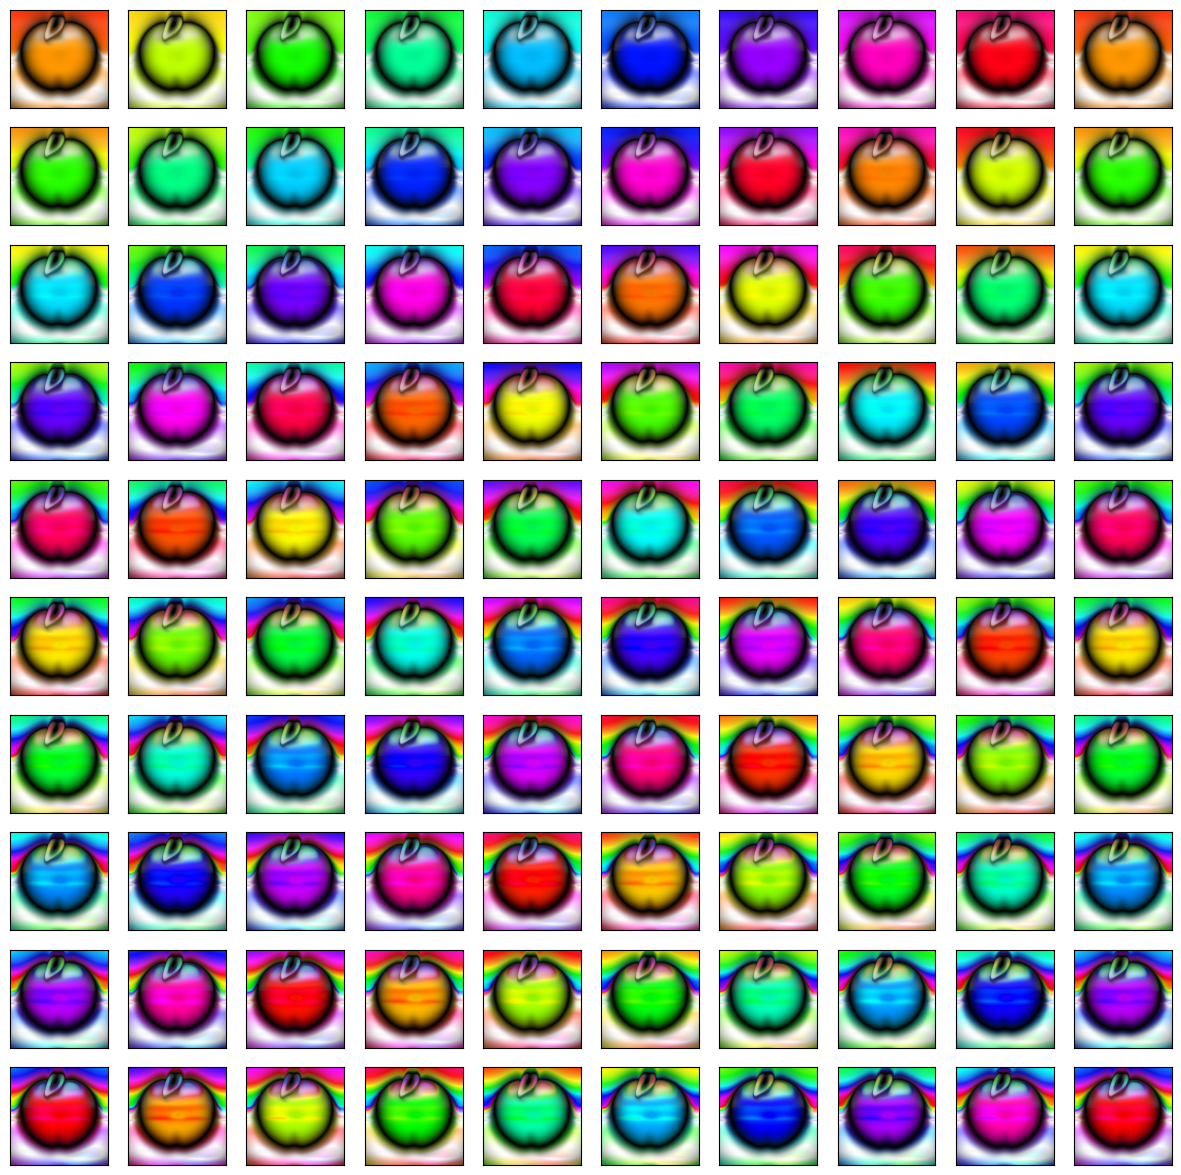

In [215]:
iplt = 0
plt.figure(figsize=(15, 15))
for j in np.linspace(.1, 2., 10):
    for i in np.linspace(0, 1., 10):
        hp = (h*j+i)%1
        hsv = np.stack([hp, s, v], axis=-1)
        rgb = jax.vmap(jax.vmap(hsv2rgb))(hsv)
        iplt += 1
        plt.subplot(10, 10, iplt)
        plt.imshow(rgb); plt.xticks([]); plt.yticks([])
plt.show()

In [15]:
def hsv2rgb_impl(hsv):
    h, s, v = hsv
    h = h * 360.

    c = v * s
    x = c * (1 - jnp.abs((h / 60) % 2 - 1))
    m = v - c
    rgbp1, c1 = jnp.stack([c, x, 0], axis=-1), (0 <= h)*(h<60)
    rgbp2, c2 = jnp.stack([x, c, 0], axis=-1), (60 <= h)*(h<120)
    rgbp3, c3 = jnp.stack([0, c, x], axis=-1), (120 <= h)*(h<180)
    rgbp4, c4 = jnp.stack([0, x, c], axis=-1), (180 <= h)*(h<240)
    rgbp5, c5 = jnp.stack([x, 0, c], axis=-1), (240 <= h)*(h<300)
    rgbp6, c6 = jnp.stack([c, 0, x], axis=-1), (300 <= h)*(h<360)
    rgbp = rgbp1 * c1 + rgbp2 * c2 + rgbp3 * c3 + rgbp4 * c4 + rgbp5 * c5 + rgbp6 * c6
    rgb = rgbp + m
    return rgb.clip(0., 1.)

def rgb2hsv_impl(rgb):
    r, g, b = rgb
    cmax = jnp.maximum(jnp.maximum(r, g), b)
    cmin = jnp.minimum(jnp.minimum(r, g), b)
    delta = cmax - cmin
    v = cmax


    s = delta / (cmax + 1e-8)
    h1, c1 = 0, (delta==0)
    h2, c2 = ((g-b)/delta % 6) * 60, (r==cmax)*(delta!=0)
    h3, c3 = ((b-r)/delta + 2) * 60, (g==cmax)*(delta!=0)
    h4, c4 = ((r-g)/delta + 4) * 60, (b==cmax)*(delta!=0)

    h = h1 * c1 + h2 * c2 + h3 * c3 + h4 * c4
    h = h/360
    return jnp.stack([h, s, v]).clip(0., 1.)

def hsv2rgb(hsv):
    return np.array(jax.vmap(jax.vmap(hsv2rgb_impl))(hsv))
def rgb2hsv(rgb):
    return np.array(jax.vmap(jax.vmap(rgb2hsv_impl))(rgb))



# rgb2hsv(np.array([0.99607843, 0.99607843, 0.99607843]))
    

In [268]:
rgb = plt.imread("/Users/akarshkumar0101/spaghetti_old/spaghetti/pbRender/renderedImages/image5736.jpg")/255.
hsv = jax.vmap(jax.vmap(rgb2hsv))(rgb)
rgb2 = jax.vmap(jax.vmap(hsv2rgb))(hsv)

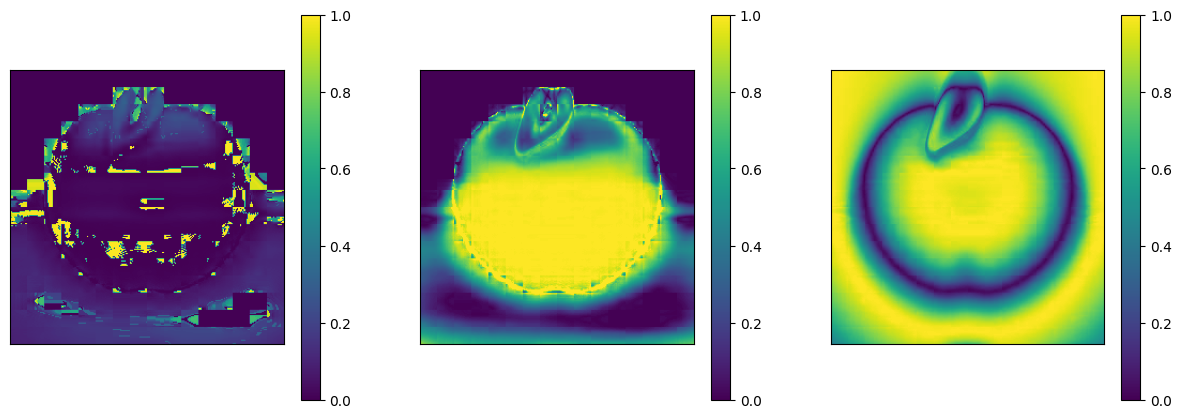

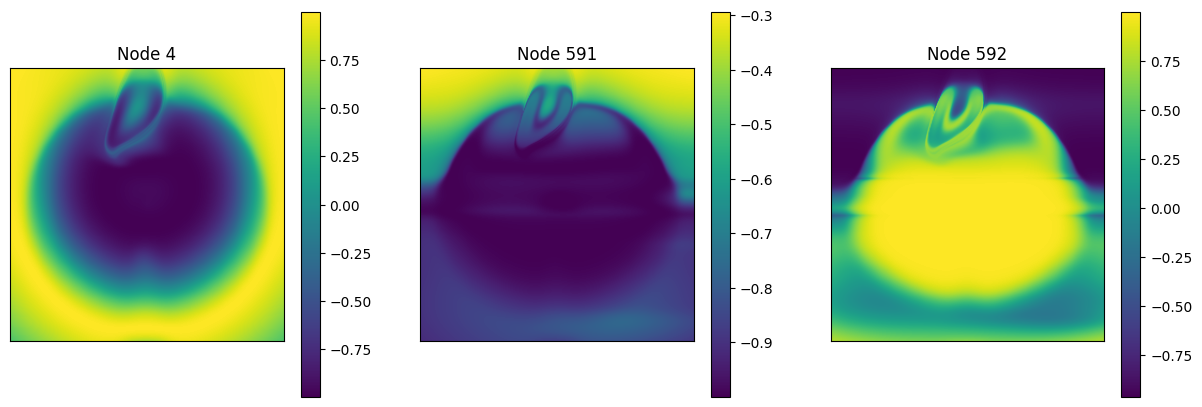

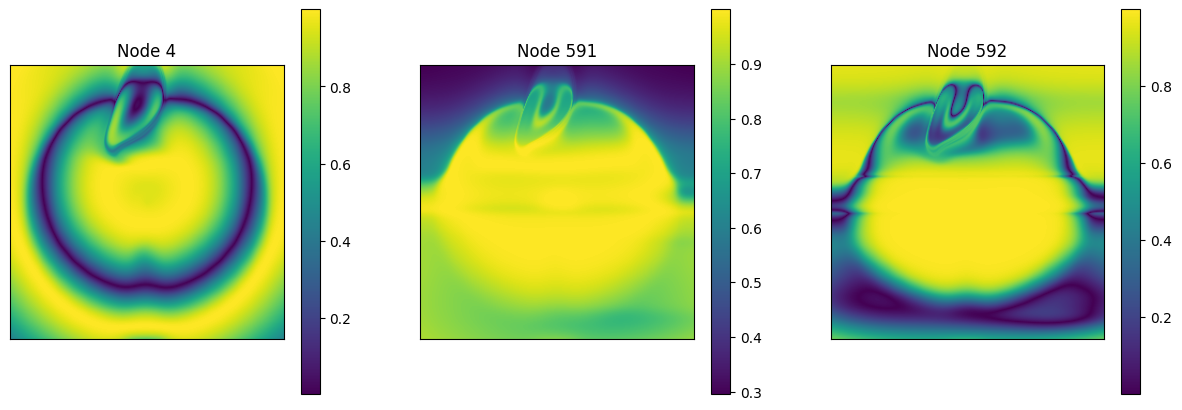

In [290]:
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(hsv[:, :, i]); plt.xticks([]); plt.yticks([])
    plt.colorbar()
plt.show()

iplt = 0
plt.figure(figsize=(15, 5))
for node_id in nn['out_node_ids']:
    iplt += 1
    plt.subplot(1, 3, iplt)
    plt.title(f"Node {node_id}")
    plt.imshow(out[node_id])
    plt.colorbar()
    plt.xticks([]); plt.yticks([])
plt.show()

iplt = 0
plt.figure(figsize=(15, 5))
for node_id in nn['out_node_ids']:
    iplt += 1
    plt.subplot(1, 3, iplt)
    plt.title(f"Node {node_id}")
    plt.imshow(np.abs(out[node_id]))
    plt.colorbar()
    plt.xticks([]); plt.yticks([])
plt.show()


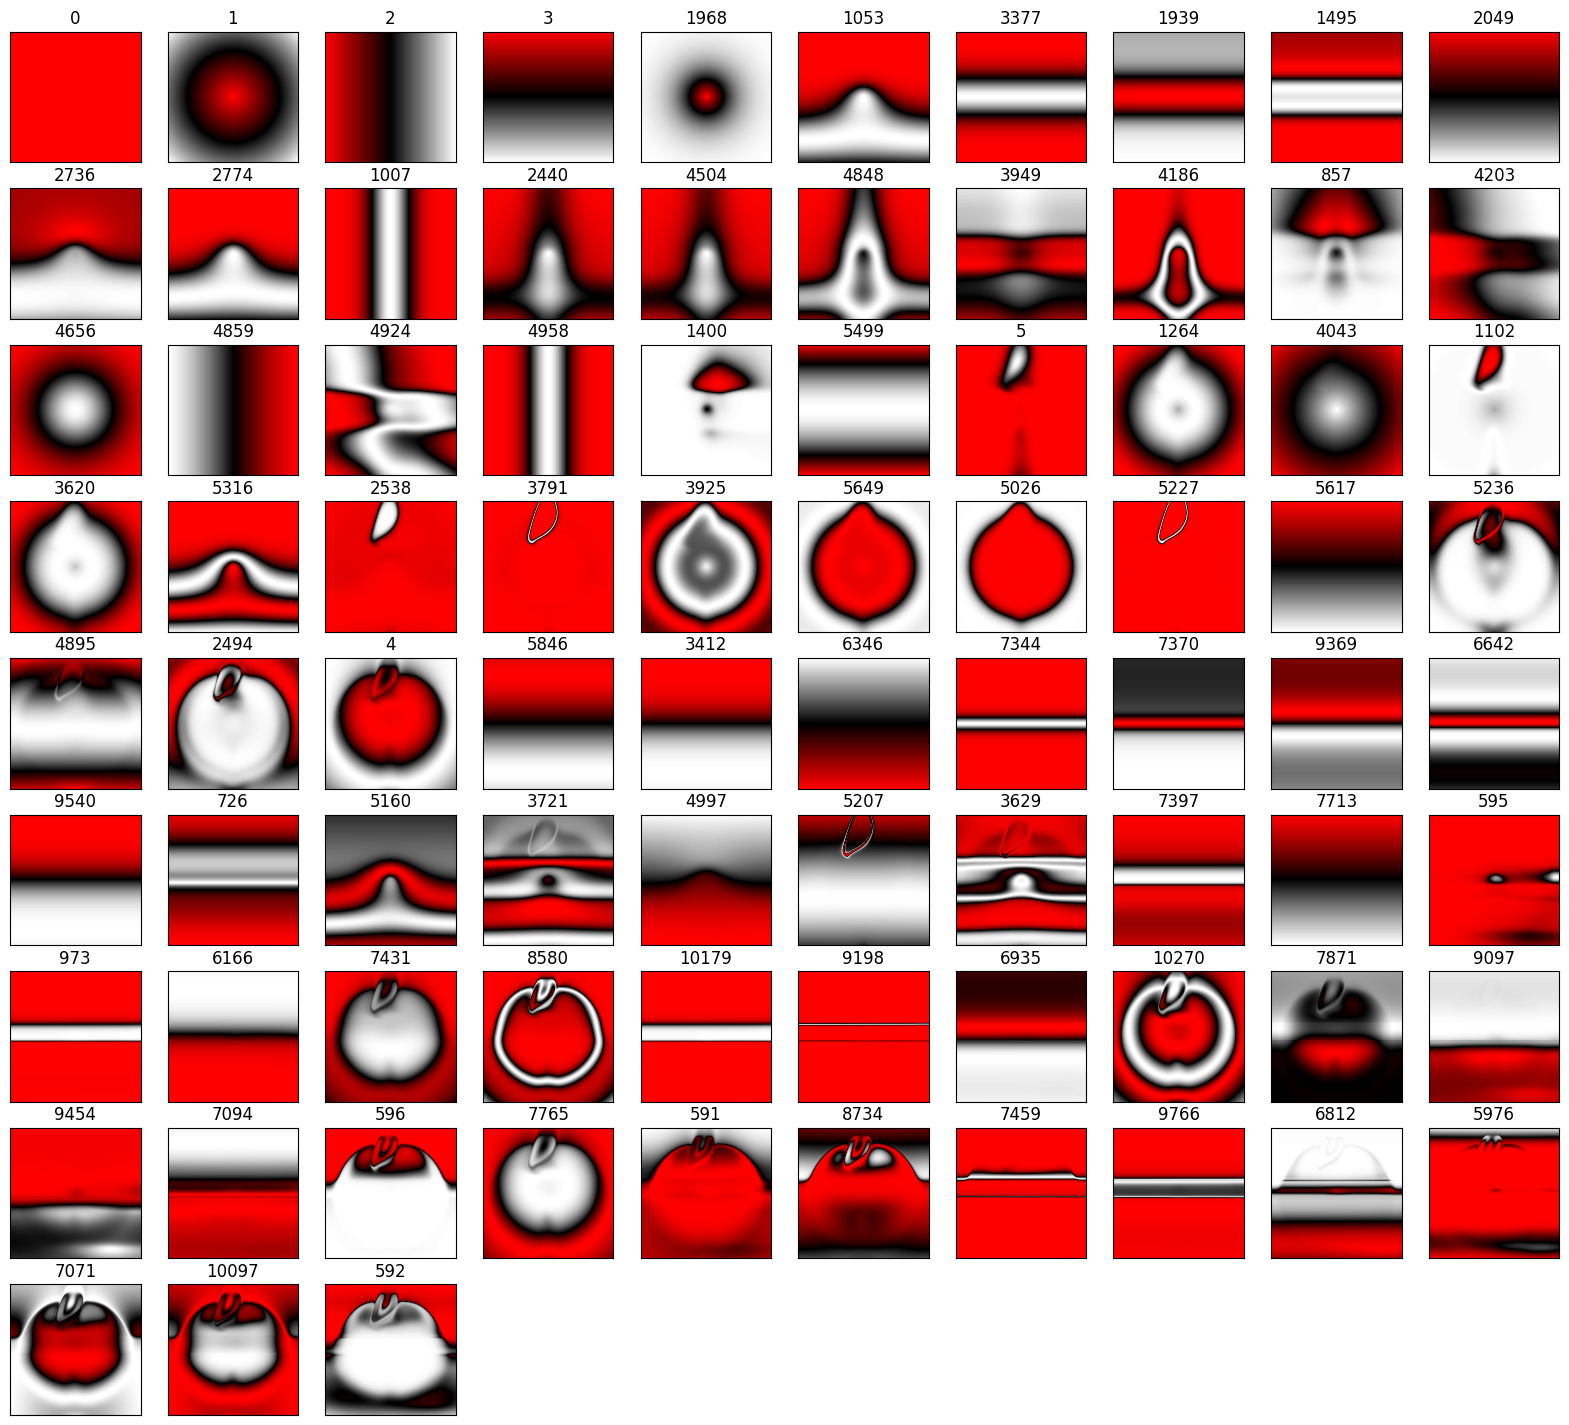

In [120]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("red_black_white", [ (1, 0, 0), (0, 0, 0), (1, 1, 1), ])

plt.figure(figsize=(20, 20))
iplt = 0
for k, v in out.items():
    iplt += 1
    plt.subplot(10, 10, iplt)
    plt.imshow(v, cmap=cmap)
    plt.title(k)
    plt.xticks([]); plt.yticks([])
plt.show()

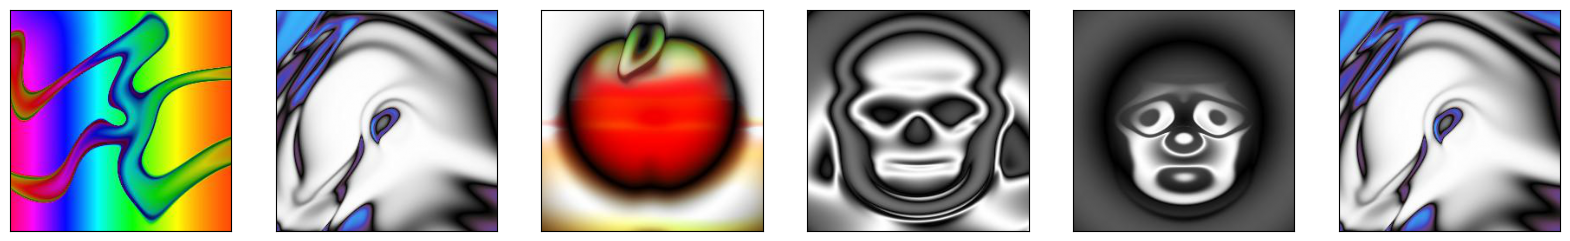

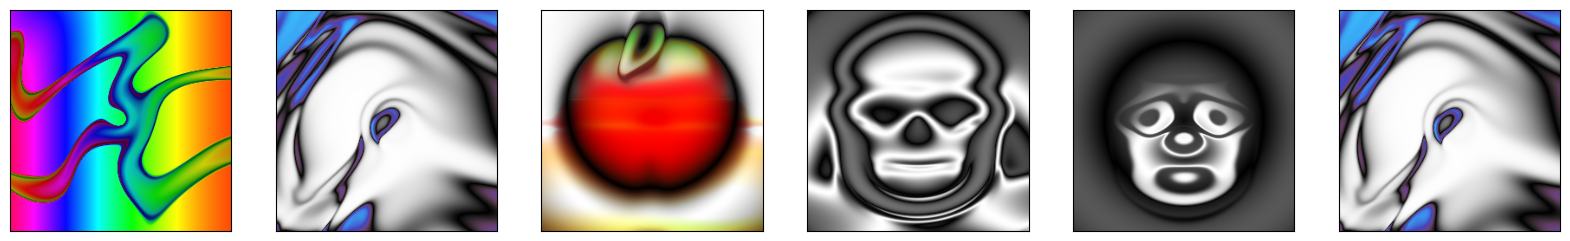

In [15]:


pids = [4009, 9382, 5736, 576, 613, 5137]
# pids = [4009, 9382, 5736, 576, 613, 4376]
# pids = [4009, 9382, 5736]

pids = [4009, 9382, 5736, 576, 613, 9382]
plt.figure(figsize=(20, 5))
for iplt, pid in enumerate(pids):
    rgb = get_image_load(pid)
    plt.subplot(1, 6, iplt+1)
    plt.imshow(rgb); plt.xticks([]); plt.yticks([])
plt.show()

plt.figure(figsize=(20, 5))
for iplt, pid in enumerate(pids):
    rgb, nn = get_image_cppn(pid)
    plt.subplot(1, 6, iplt+1)
    plt.imshow(rgb); plt.xticks([]); plt.yticks([])
plt.show()

In [345]:
[(l['source'], l['target']) for l in nn['links'] if l['target']==258 and l['source']==5]

[(5, 258)]

In [344]:
[(l['source'], l['target']) for l in nn['links'] if l['target']==5 and l['source']==258]

[(258, 5)]

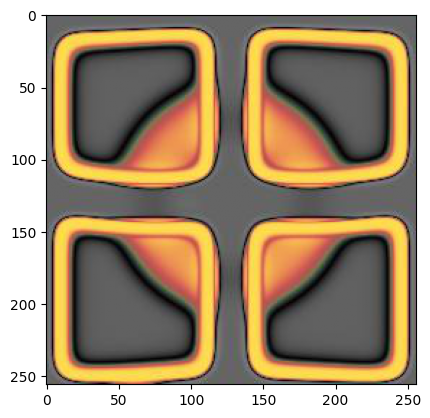

CYCLE: [1180, 502, 503, 1529, 169, 711]
CYCLE: [1180, 502, 503, 1529, 169, 711, 5]
CYCLE: [1180, 502, 503, 1529, 169]


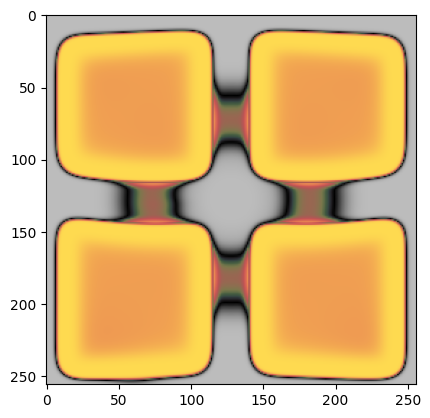

In [248]:
pid = 4323
rgb = get_image_load(pid)
plt.imshow(rgb)
plt.show()
rgb, nn = get_image_cppn(pid)
plt.imshow(rgb)

In [283]:
links[502]

[1180, 1181, 1184, 1185]

In [268]:
links = {}
for link in nn['links']:
    if link['source'] not in links:
        links[link['source']] = []
    links[link['source']].append(link['target'])

In [286]:
[link for link in nn['links'] if link['source']==711 and link['target']==169]

[{'id': 170, 'source': 711, 'target': 169, 'weight': 1.1410820894118818}]

In [333]:
def nn_forward_new(nn):
    res = 256
    x = y = np.linspace(-1., 1., res)
    x, y = np.meshgrid(x, y)
    d = np.sqrt(x**2 + y**2)*1.4

    nodes, links = nn['nodes'], nn['links']
    # nodes = [n['id'] for n in nn['nodes']]
    # links = [(l['source'], l['target'], l['weight']) for l in nn['links']]
    node2activation = {n['id']: n['activation'] for n in nn['nodes']}
    node2in_links = {n['id']: [(l['source'], l['weight']) for l in nn['links'] if l['target'] == n['id']] for n in nn['nodes']}
    node2out_links = {n['id']: [(l['target'], l['weight']) for l in nn['links'] if l['source'] == n['id']] for n in nn['nodes']}
    node2type = {n['id']: n['type'] for n in nn['nodes']}
    node2label = {n['id']: (n['label'] if 'label' in n else None) for n in nn['nodes']}
    node_x = [node['id'] for node in nn['nodes'] if node['label']=='x'][0]
    node_y = [node['id'] for node in nn['nodes'] if node['label']=='y'][0]
    node_d = [node['id'] for node in nn['nodes'] if node['label']=='d'][0]
    node_bias = [node['id'] for node in nn['nodes'] if node['label']=='bias'][0]
    nodes_out = [node for node in nodes if node['type']=='out']
    output = {node_x: x, node_y: y, node_d: d, node_bias: np.ones_like(x)}
    current_layer = [node_x, node_y, node_d, node_bias]

    while current_layer:
        next_layer = []
        for node in current_layer:
            if node in output:
                continue
            for out, weight, in_links
            in_links = node2in_links[node]
            activation_fn = activation_fn_map[node2activation[node][:-3]]
            val = 0.
            for src_id, weight in in_links:
                val += output[src_id] * weight
            output[node] = activation_fn(val)
            next_layer.extend([link[0] for link in node2out_links[node]])
        current_layer = next_layer


nn_forward_new(nn)


{1180: 0}
LAYER 0
{1184, 1185, 502}
LAYER -1
{36, 1735, 1610, 561, 498, 499, 500, 501, 86, 503, 699}
LAYER -2
{160, 1061, 711, 1544, 169, 362, 781, 1713, 1012, 1653, 983, 1688, 1529, 636, 191}
LAYER -3
{769, 5, 837, 936, 1640, 1036, 45, 118, 1663}
LAYER -4
set()


In [336]:
[l for l in nn['links'] if l['target']==711]

[{'id': 712, 'source': 1529, 'target': 711, 'weight': -0.6080782972040074},
 {'id': 7, 'source': 5, 'target': 711, 'weight': -0.6413927867438776}]

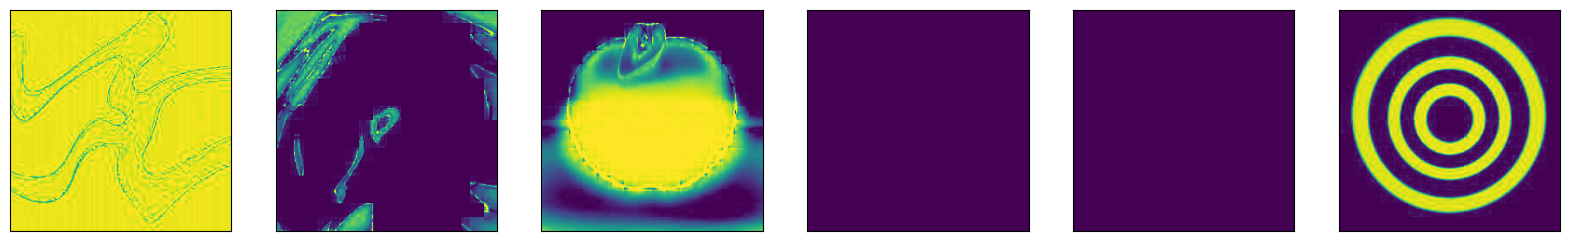

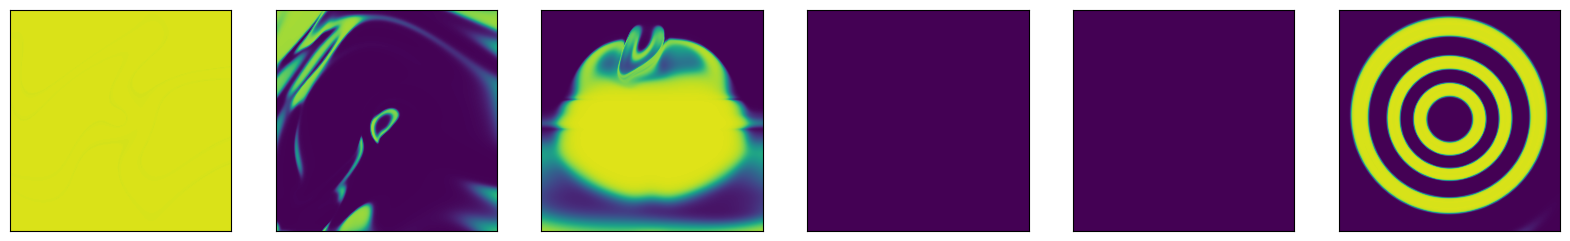

In [164]:
pids = [4009, 9382, 5736, 576, 613, 5137]

data = []
for get_image in [get_image_load, get_image_cppn]:
    plt.figure(figsize=(20, 5))
    for iplt, pid in enumerate(pids):
        rgb = get_image(pid)
        r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
        h, s, v = rgb2hsv(r, g, b)
        plt.subplot(1, 6, iplt+1)
        plt.imshow(s, vmin=0, vmax=1.); plt.xticks([]); plt.yticks([])
        data.extend([h, s, v])
    plt.show()

In [95]:
data = np.stack(data)
data = data.reshape(2, 6, 3, 256, 256)
data.shape

(2, 6, 3, 256, 256)

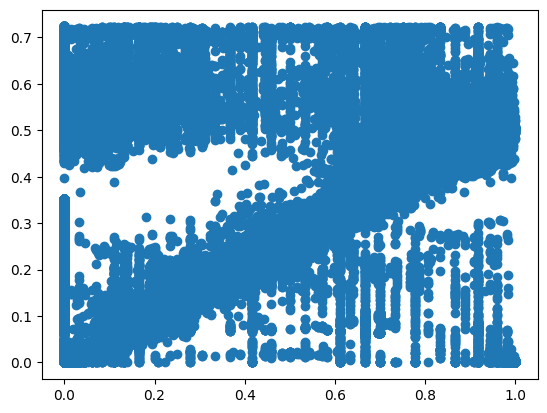

In [103]:
v1 = data[0, :3, 0, :, :]
v2 = data[1, :3, 0, :, :]
plt.scatter(v1.flatten(), v2.flatten())

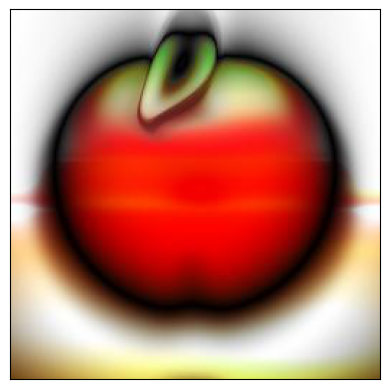

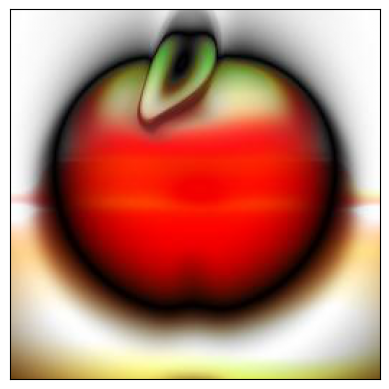

In [11]:
def hsv2rgb(h, s, v):
    h = h * 360.

    c = v * s
    x = c * (1 - np.abs((h / 60) % 2 - 1))
    m = v - c

    r1, g1, b1, c1 = c, x, 0, (0 <= h)*(h<60)
    r2, g2, b2, c2 = x, c, 0, (60 <= h)*(h<120)
    r3, g3, b3, c3 = 0, c, x, (120 <= h)*(h<180)
    r4, g4, b4, c4 = 0, x, c, (180 <= h)*(h<240)
    r5, g5, b5, c5 = x, 0, c, (240 <= h)*(h<300)
    r6, g6, b6, c6 = c, 0, x, (300 <= h)*(h<360)

    r = r1 * c1 + r2 * c2 + r3 * c3 + r4 * c4 + r5 * c5 + r6 * c6
    g = g1 * c1 + g2 * c2 + g3 * c3 + g4 * c4 + g5 * c5 + g6 * c6
    b = b1 * c1 + b2 * c2 + b3 * c3 + b4 * c4 + b5 * c5 + b6 * c6
    r, g, b = r + m, g + m, b + m
    return r.clip(0., 1.), g.clip(0., 1.), b.clip(0., 1.)

def rgb2hsv(r, g, b):
    cmax = np.maximum(np.maximum(r, g), b)
    cmin = np.minimum(np.minimum(r, g), b)
    delta = cmax - cmin
    v = cmax
    
    s1, c1 = np.zeros_like(delta), (cmax==0)
    s2, c2 = delta / (cmax+1e-8), (cmax!=0)
    s = s1 * c1 + s2 * c2

    h1, c1 = np.zeros_like(g), (delta==0)
    h2, c2 = ((g-b)/(delta+1e-8) % 6) * 60, (r==cmax)*(delta!=0)
    h3, c3 = ((b-r)/(delta+1e-8) + 2) * 60, (g==cmax)*(delta!=0)*(r!=cmax)
    h4, c4 = ((r-g)/(delta+1e-8) + 4) * 60, (b==cmax)*(delta!=0)*(g!=cmax)*(r!=cmax)

    h = h1 * c1 + h2 * c2 + h3 * c3 + h4 * c4
    h = h/360
    return h.clip(0., 1.), s.clip(0., 1.), v.clip(0., 1.)
rgb = get_image_load(5736)
r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
plt.imshow(np.stack([r, g, b], axis=-1)); plt.xticks([]); plt.yticks([]);plt.show()
h, s, v = rgb2hsv(r, g, b)
r, g, b = hsv2rgb(h, s, v)
plt.imshow(np.stack([r, g, b], axis=-1)); plt.xticks([]); plt.yticks([]);plt.show()

In [63]:
img = []
data = []
for i in tqdm(range(len(xyd))):
    x, y, d = xyd[i]
    a, b = get_value(ns, ls, x, y, d)
    img.append(a)
    data.append(b)
data = jax.tree.map(lambda *x: jnp.array(x).reshape(res, res), *data)

  0%|          | 0/65536 [00:00<?, ?it/s]

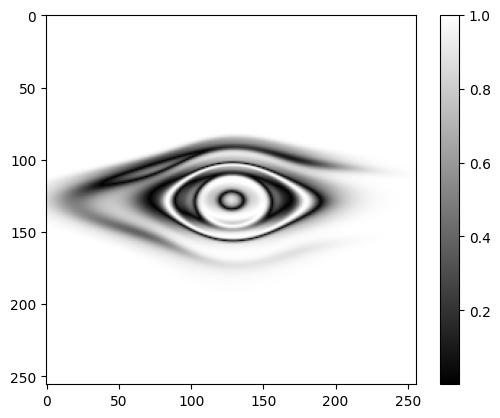

In [64]:
img = np.array(img).reshape(res, res)
img = np.abs(img)
plt.imshow(img, cmap='gray')
plt.colorbar()
plt.show()

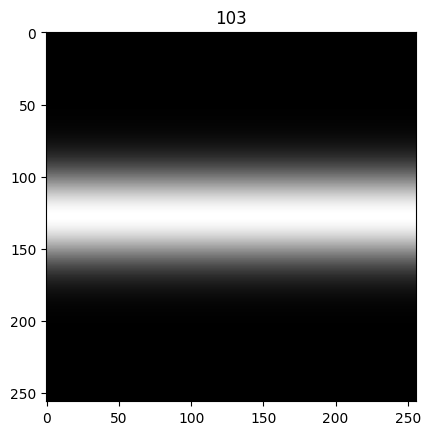

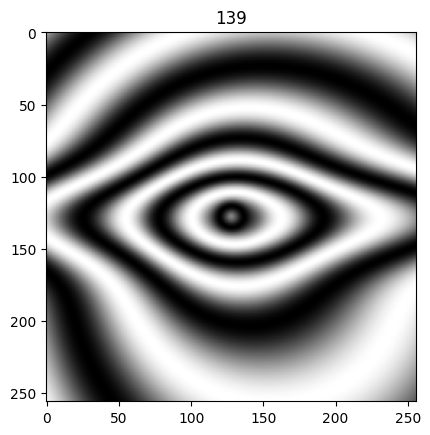

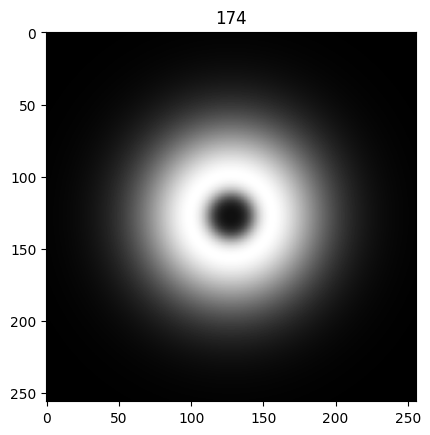

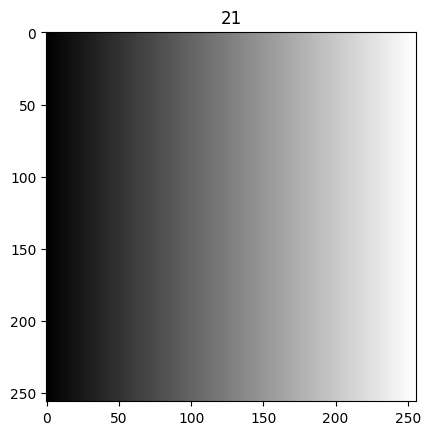

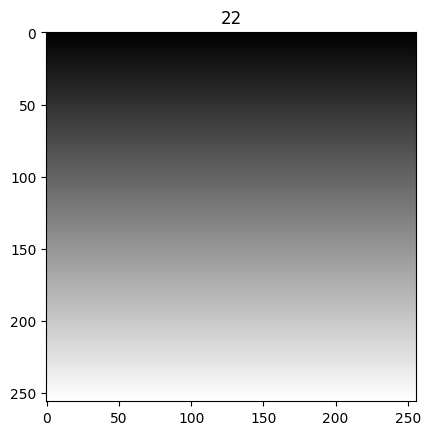

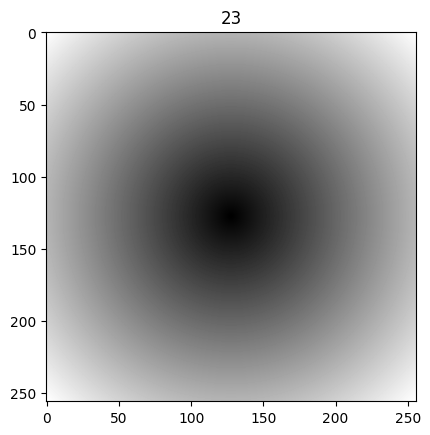

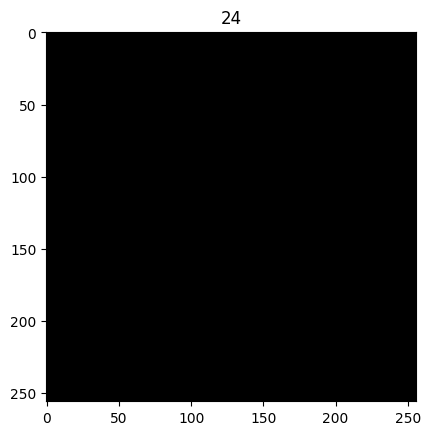

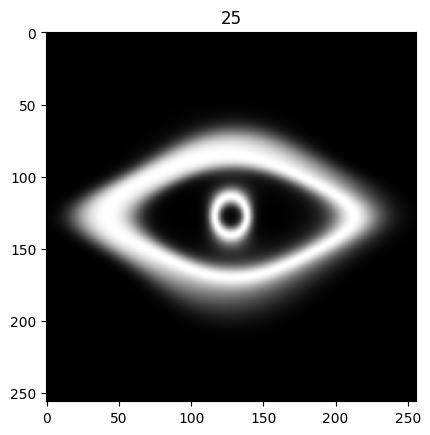

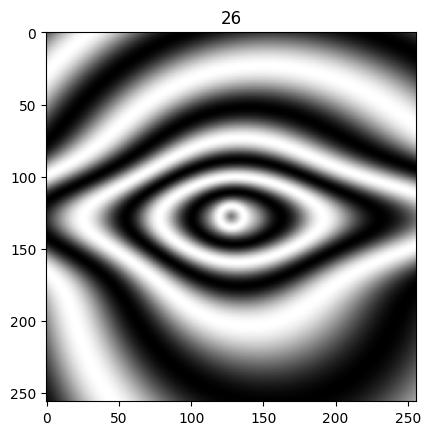

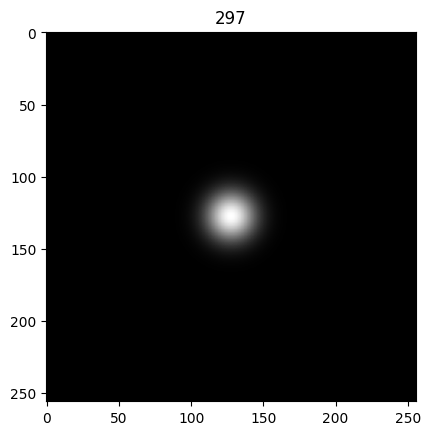

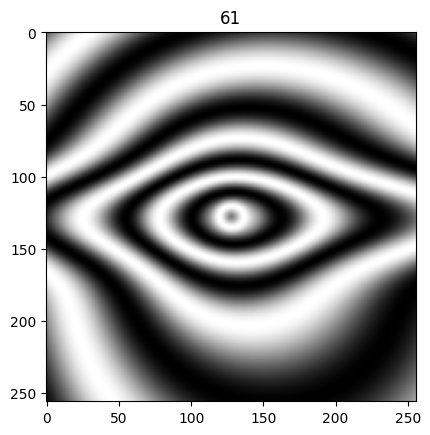

In [39]:
for k, v in data.items():
    plt.imshow(v, cmap='gray')
    plt.title(k)
    plt.show()

In [74]:
#define FREQUENCY 0.001
#define RESOLUTION 1000
#define SIGMOID_LOW -7.6014025936126712
#define SIGMOID_HIGH 7.6013787517547611
#define SIGMOID_DIF 15.202781345367432
#define SIGMOID_SIZE 15203
#define GAUSSIAN_LOW -2.7579733983037391
#define GAUSSIAN_HIGH 2.7579733983037391
#define GAUSSIAN_DIF 5.5159467966074782
#define GAUSSIAN_SIZE 5516
# double actualSigmoid ( double input ) {
#     return (1.0 / (1+std::exp(float(-input)))) * 2.0 - 1.0;
# }

# double actualGaussian ( double input ) {
#     return std::exp(float(-input*input)) * 2.0 - 1.0;
# }


FREQUENCY = 0.001
RESOLUTION = 1000
SIGMOID_LOW = -7.6014025936126712
SIGMOID_HIGH = 7.6013787517547611
SIGMOID_DIF = 15.202781345367432
SIGMOID_SIZE = 15203
GAUSSIAN_LOW = -2.7579733983037391
GAUSSIAN_HIGH = 2.7579733983037391
GAUSSIAN_DIF = 5.5159467966074782
GAUSSIAN_SIZE = 5516


def actualSigmoid(x):
    return (1.0 / (1+np.exp(-x))) * 2.0 - 1.0

def actualGaussian(x):
    return np.exp(-x*x) * 2.0 - 1.0




# double findPoint(ActivationFunctionPt f, double center, double boundary, double tolerance){
#     double extreme = (*f)(boundary);

#     for (int i = 0; i < 1000; i++) {
#         double m = (center + boundary) / 2.0;
#         if (std::abs(f(m) - extreme) < tolerance)
#             boundary = m;
#         else {
#             center = m;
#         }
#     }
#     return boundary;
# }
# void SampledBoundedFunction(ActivationFunctionPt function, double* table, double& low, double& high, int& offset, int size){
#     low = (findPoint(function, 0.0, -100.0, FREQUENCY) - FREQUENCY);
#     high = (findPoint(function, 0.0, 100.0, FREQUENCY) + FREQUENCY);

#     offset = ((int)(-low * RESOLUTION));
# //		table = new double[(int)((high - low) * RESOLUTION) + 1];

#     for (int i = 0; i < size; i++){
# //			std::cout << "i: " << i << " : "<< (*function)((i - offset) * FREQUENCY) << std::endl;
#         table[i] = (*function)((i - offset) * FREQUENCY);
#     }
# }


def find_point(fn, center, boundary, tolerance):
    extreme = fn(boundary)
    for _ in range(1000):
        m = (center + boundary) / 2.0
        if np.abs(fn(m) - extreme) < tolerance:
            boundary = m
        else:
            center = m
    return boundary



def sampled_bounded_function(fn, low, high, offset, size):
    low = find_point(fn, 0.0, -100.0, FREQUENCY) - FREQUENCY
    high = find_point(fn, 0.0, 100.0, FREQUENCY) + FREQUENCY
    offset = int(-low * RESOLUTION)
    table = np.zeros(size)
    for i in range(size):
        table[i] = fn((i - offset) * FREQUENCY)
    return table


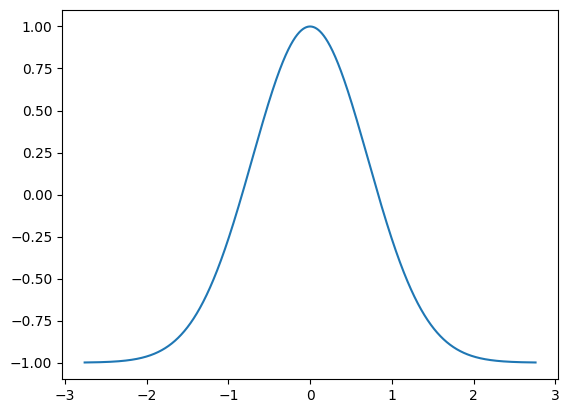

In [75]:
x = np.linspace(GAUSSIAN_LOW, GAUSSIAN_HIGH, GAUSSIAN_SIZE)
y = actualGaussian(x)
plt.plot(x, y)

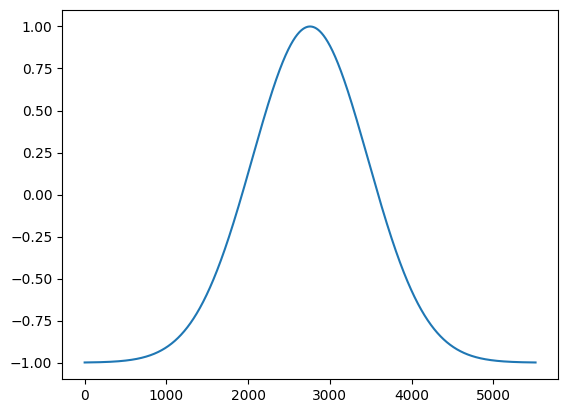

In [77]:
plt.plot(sampled_bounded_function(actualGaussian, GAUSSIAN_LOW, GAUSSIAN_HIGH, 0, GAUSSIAN_SIZE))
